**expected behaviour:**
1. scan the terrain
2. locate panel
3. drive toward (close to the) panel

**algorithm:**
1. video acquisition
2. panel highlighting
    1. terrain remotion
    2. filtering
3. roi identification
    1. contours
    1. bounding box and center
4. motion
    1. motion direction
    2. motion performance
5. panel tracking
    1. roi features
    2. features matching
    3. moved roi estimation


**to understand:**

faster/less computational expensive perform 1...4...1... or 1...5...5... ?

In [13]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import glob

###################################################################################################
###################################################################################################
# SOURCE IMAGE/VIDEO STREAM ACQUISITION
def videoGe(sourceVideo):
    objectVideo = cv.VideoCapture(sourceVideo)
    if objectVideo.isOpened():
        returnCapture, frameCapture =objectVideo.read()
        heightFrame,widthFrame,_=frameCapture.shape
        return frameCapture,(heightFrame,widthFrame)
    else: objectVideo.release(); return 0

###################################################################################################
###################################################################################################
# FOREGROUND/BACKGROUND SEPARATION
def panelFy(srcImg):
    

    # histogram param, for hs(v) space
    hBins = 180
    sBins = 255
    histSize = [hBins, sBins]
    hRanges = [1, 180]
    sRanges = [1, 256]
    Ranges = hRanges + sRanges
    Channels = [0, 1]

    # histogram(cdf) comparison method
    histCompLib = (
        ("Correlation", cv.HISTCMP_CORREL, 0.2),#or  0.4
        ("Chi-Squared", cv.HISTCMP_CHISQR, 10000000),
        ("Intersection", cv.HISTCMP_INTERSECT, 0.45),
        ("Hellinger", cv.HISTCMP_BHATTACHARYYA, 0),
        ("Kullback-Leibler",cv.HISTCMP_KL_DIV, 500))

    # choosen method and comparison threshold
    _,histCompMet, histCompThr =histCompLib[0]

    ############################
    # samples folder
    samplePath='../../images/marsyard/samples/terrain/'
    # roi extraction methods   
    sampleMetLib=('library',
            'stream')
    # selected roi extraction method
    sampleMet=sampleMetLib[0]
    ##############################
    # mask's filter param and threshold value (mask is decimal)
    if sampleMet=='library':      
        sizeElMask=3
        tyElMask=cv.MORPH_RECT
        thrValMask=10#CORREL:10, CHISQR:0-20,

    elif sampleMet=='stream':
        numElMask=4
        dimRowMask=img.shape[0]//numElMask
        dimColMask=img.shape[1]//numElMask

        sizeElMask=4
        tyElMask=cv.MORPH_RECT
        thrValMask=50    
    ################################
    # source prefiltering and color
    srcImgh=cv.cvtColor(srcImg,cv.COLOR_BGR2HSV)
    
    # source histogram
    srcImghhist = cv.calcHist([srcImgh], Channels, None, histSize, Ranges, accumulate=False)
    cv.normalize(srcImghhist, srcImghhist, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
    
    # array of good samples
    niceSamples=[]
    ##may be usefull for advanced parameter passing
    # foreground mask initialization
    foreMask=np.zeros(srcImg.shape,np.uint8)

    # picks roi from samples library
    if sampleMet=='library':
        for tempLibImg in glob.glob(samplePath+"*.jpg"):## manages only .jpg
            # roi acquisition
            tempLibImg=cv.cvtColor(cv.imread(tempLibImg),cv.COLOR_BGR2HSV)
            # roi hist
            roihhist= cv.calcHist([tempLibImg], Channels, None, histSize, Ranges, accumulate=False)
            cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
               # roi correlation test
            if cv.compareHist(srcImghhist, roihhist, histCompMet)>histCompThr:
                # usefull roi saved
                niceSamples.append(tempLibImg)
                # roi mask, mask smoothing and binarization, 3 channels conversion
                bpMask = cv.calcBackProject([srcImgh],Channels,roihhist,Ranges,1)
                cv.filter2D(bpMask,-1,cv.getStructuringElement(tyElMask,(sizeElMask,sizeElMask)),bpMask)
                _,thrChanMask = cv.threshold(bpMask,thrValMask,255,0)
                # foreground mask
                foreMask=cv.bitwise_or(foreMask,cv.merge((thrChanMask,thrChanMask,thrChanMask)))

    # picks roi from target image itself
    elif sampleMet=='stream':
        # target grid division
        for jj in range(0,srcImg.shape[0],dimRowMask):
            for ii in range(0,srcImg.shape[1],dimColMask):
                # roi acquisition
                tempLibImg=cv.cvtColor(srcImg[jj:jj+dimRowMask,ii:ii+dimColMask],cv.COLOR_BGR2HSV)
                # roi histogram
                roihhist= cv.calcHist([tempLibImg], Channels, None, histSize, Ranges, accumulate=False)
                cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
                # roi correlation test
                if cv.compareHist(srcImghhist, roihhist, histCompMet)>histCompThr:
                    # usefull roi saved
                    niceSamples.append(tempLibImg)
                    # roi mask, mask smoothing and binarization, 3 channels conversion
                    bpMask = cv.calcBackProject([srcImgh],Channels,roihhist,Ranges,1)
                    cv.filter2D(bpMask,-1,cv.getStructuringElement(tyElMask,(sizeElMask,sizeElMask)),bpMask)
                    _,thrChanMask = cv.threshold(bpMask,thrValMask,255,0)
                    # foreground mask
                    foreMask=cv.bitwise_or(foreMask,cv.merge((thrChanMask,thrChanMask,thrChanMask)))

    # foreground mask
    foreMask=cv.bitwise_not(foreMask)
    # masked source image
    foreResImg = cv.bitwise_and(srcImg,foreMask)
    return foreResImg

###################################################################################################
###################################################################################################
# ROI HIGHLIGHTING
def roiFy():
    def closeCnt(image2close):
        kernel = np.ones((25,25),np.uint8)#cv.getStructuringElement(cv.MORPH_RECT,(10,10)) 
        image2close=cv.morphologyEx(image2close,cv.MORPH_CLOSE,kernel)
        image2close=cv.morphologyEx(image2close,cv.MORPH_RECT,kernel)
        kernel =cv.getStructuringElement(cv.MORPH_RECT,(10,10))
        image2close=cv.dilate(image2close,kernel,iterations=2)
        kernel = np.ones((15,15),np.uint8)
        image2close=cv.morphologyEx(image2close,cv.MORPH_OPEN,kernel)
    return image2close

    # RETURN ROI RECTANGLE AND ROI CENTER AND COSMETICHS
    def roiHud(image2hud,cnt2hud,hull2hud=[],nocount=1,nohull=1,norect=0,nocentr=0):
        # draw max contour
        if not nocount:cv.drawContours(image2hud, cnt2hud, -1,(25,205,255), 10)

        # draw convex hull
        if not nohull:cv.drawContours(image2hud, [hull2hud], -1, (255, 255, 0), 5)

        # rotated rect 
#         rect = cv.minAreaRect(cnt2hud)
#         box = np.int0(cv.boxPoints(rect))
#         cv.drawContours(image2hud, [box], 0, (0,0,255), 8)

        # bounding rect and center
        xRHud,yRHud,wRHud,hRHud = cv.boundingRect(cnt2hud)
        if not norect:cv.rectangle(image2hud, (xRHud,yRHud), (xRHud+wRHud,yRHud+hRHud), (255,0,255), 5)

        # rectangle center
        xcRHud,ycRHud=xRHud+wRHud//2, yRHud+hRHud//2
        if not nocentr:cv.circle(image2hud, (xcRHud,ycRHud), 15, (0,255,0), 18)

        return image2hud, (xcRHud, ycRHud),(wRHud,hRHud)
    return 0

###################################################################################################
###################################################################################################
# ROBOT MOTION SIMULATION
def moveRob():
    return 0

###################################################################################################
###################################################################################################
# PANEL TRACKING FUNCTION
def panelTra():
    return 0

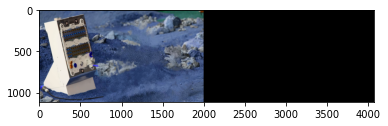

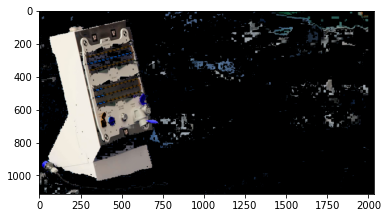

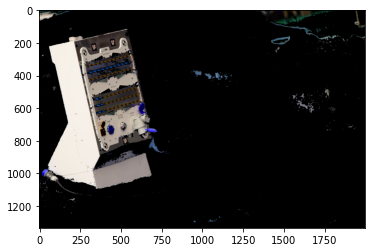

In [20]:
videoSrc='../../images/video/task_ext.avi'

frameVid,frameForm=videoGe(videoSrc)
plt.imshow(frameVid);plt.show()

maskedImg=panelFy(frameVid)
plt.imshow(maskedImg[:,:(maskedImg.shape[1])//2]);plt.show()

if 0:# test with imported image
    plt.imshow(panelFy(cv.imread('../../images/marsyard/taskfinal.jpg')));plt.show()


